## Imports and Functions

In [1]:
# Math Packages
import numpy as np
import torch as torch
from scipy import interpolate
from scipy.optimize import minimize
import time as time
import pandas as pd
import emcee

# Plotting
import matplotlib.pyplot as plt  
from matplotlib.pyplot import figure
from matplotlib import cm
#matplotlib format
import corner
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

# Data saving packages
from pickle import dump, load
import itertools

# Parallelization
from dask import config as cfg
import dask
from dask.distributed import Client, progress
from multiprocessing import Pool
import multiprocessing as mp
import os
# mp.set_start_method('fork')
# os.environ["OMP_NUM_THREADS"] = "1" 

# GP

In [2]:
def se_kernel(x1, x2, l, width):
    K = width**2 * torch.exp(-(torch.cdist(x1/l,x2/l,p=2)**2)/2)
    return K

def local_surrogate(Xi, Xd, l, width, y, KddInv, μd):
    V     = torch.stack([((n/(n-6))*((n/6)**((6)/(n-6))))*e*((s/r_pr)**n - (s/r_pr)**6) for n,s,e in zip(Xi[:,0],Xi[:,1],Xi[:,2])])
    pmf_μ = torch.exp(-V/kbT)
    μ    = torch.zeros([len(Xi), qnum])
    for i in range (len(pmf_μ)):
        μ[i]  = rdf2sq2(r_pr, pmf_μ[i], q, ρ) + 1 
    
    Kid = se_kernel(Xi, Xd, l, width)
    return (μ+(Kid @ KddInv) @ (y-μd)).T

def local_surrogate1(Xi, Xd, l, width, y, KddInv, μd):   
    Kid = se_kernel(Xi, Xd, l, width)
    return (1+(Kid @ KddInv) @ (y-1)).T

def rdf2sq2(r, rdf, q, ρ):
    import numpy as np
    dr = r[1] - r[0] 
    sq   = torch.zeros(len(q))
    for j in range (len(q)):
        sq[j] = (4*np.pi*ρ*np.trapz(r*(rdf-1)*np.sin(q[j]*r),dx = dr)/q[j])
    return sq    

## Importing the training data

In [3]:
print("Loading training data...")
input_dict = load(open('training_data/train_data.p', 'rb'))
xd = input_dict['xs']
sqs = input_dict['sqs'] 
rdfs = input_dict['rdfs']
print("Success!!!")

Loading training data...
Success!!!


In [4]:
N_particles = 1_000
density = 0.1
nsims = 960

In [5]:
rmax = (0.95/2)*((N_particles/density)**(1/3))
rmin = 0
rnum = 250
r = np.linspace(rmin,rmax,rnum)

#assume atom size of ~2.5 A^-1
qmax = np.pi/(2.5*(rmax - rmin)/rnum) #qmax in reduced space is (π/Δr)*1/2.5
qmin = 1.25                           #qmin in reduced space is qmin for standard diffractometers * 2.5 A
qnum = 236                            #qnum selected so that the spacing is approximately 0.05A^{-1} for a 2.5 A particle
q = torch.linspace(qmin,qmax,qnum) 
print('qmin =', qmin)
print('qmax =', qmax)
print('Δq =', q[1]- q[0])

qmin = 1.25
qmax = 30.698908169815425
Δq = tensor(0.1253)


In [6]:
Xd = torch.tensor(xd).float()
y = torch.tensor(sqs).float()

n = len(Xd)
η = len(q)

index = torch.arange(0,len(Xd),1)

kbT   = 1
ρ     = 0.1
r_pr  = torch.linspace(0.0001, 20, 1000)
Vd    = torch.stack([((n/(n-6))*((n/6)**((6)/(n-6))))*e*((s/r_pr)**n - (s/r_pr)**6) for n,s,e in zip(Xd[:,0],Xd[:,1],Xd[:,2])])
pmf_r = np.exp(-Vd/kbT)
μd    = torch.zeros([nsims, qnum])
for i in range (len(pmf_r)):
    μd[i]  = rdf2sq2(r_pr, pmf_r[i], q, ρ) + 1

In [7]:
def g(θ):
    
    l = torch.tensor([θ[0],θ[1],θ[2]]).float()
    w = torch.tensor(θ[3]).float()
    σn = torch.tensor(θ[4]).float()
    
    Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
    KddInv = torch.linalg.inv(Kdd)
    
    KddInv_ii = torch.diagonal(KddInv, 0)
    
    logKddInv_ii = torch.log(KddInv_ii)
    
    g = (1/(2*len(Xd)))*torch.sum(((KddInv @ (y - μd)).T/(torch.sqrt(KddInv_ii).repeat(qnum,1)))**2) - (qnum/(2*len(Xd)))*torch.sum(logKddInv_ii) + (qnum/2)*np.log(2*np.pi)
    
    return g

def g1(θ):
    
    l = torch.tensor([θ[0],θ[1],θ[2]]).float()
    w = torch.tensor(θ[3]).float()
    σn = torch.tensor(θ[4]).float()
    
    Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
    KddInv = torch.linalg.inv(Kdd)
    
    KddInv_ii = torch.diagonal(KddInv, 0)
    
    logKddInv_ii = torch.log(KddInv_ii)
    
    g = (1/(2*len(Xd)))*torch.sum(((KddInv @ (y - 1)).T/(torch.sqrt(KddInv_ii).repeat(qnum,1)))**2) - (qnum/(2*len(Xd)))*torch.sum(logKddInv_ii) + (qnum/2)*np.log(2*np.pi)
    
    return g

μ_ℓ_n= 0.5
σ_ℓ_n = 1.5
prior_ℓ_n_dist = torch.distributions.normal.Normal(μ_ℓ_n, σ_ℓ_n)
def log_prior_ℓ_n(ℓ_n):
    return prior_ℓ_n_dist.log_prob(ℓ_n)

μ_ℓ_σ= 0.5
σ_ℓ_σ = 0.5
prior_ℓ_σ_dist = torch.distributions.normal.Normal(μ_ℓ_σ, σ_ℓ_σ)
def log_prior_ℓ_σ(ℓ_σ):
    return prior_ℓ_σ_dist.log_prob(ℓ_σ)

μ_ℓ_ϵ= 0.5
σ_ℓ_ϵ = 2
prior_ℓ_ϵ_dist = torch.distributions.normal.Normal(μ_ℓ_ϵ, σ_ℓ_ϵ)
def log_prior_ℓ_ϵ(ℓ_ϵ):
    return prior_ℓ_ϵ_dist.log_prob(ℓ_ϵ)

μ_w = 0
σ_w = 0.5
prior_w_dist = torch.distributions.normal.Normal(μ_w, σ_w)
def log_prior_w(w):
    return prior_w_dist.log_prob(w)

μ_σn = 0.5
σ_σn = 2
prior_σn_dist = torch.distributions.normal.Normal(μ_σn, σ_σn)
def log_prior_σn(σn):
    return prior_σn_dist.log_prob(σn)
    
    
def post_LMLH(θ):
    try:
        θ = torch.tensor(θ)
        LH = -g(θ.exp())
        if np.isnan(LH):
            return -np.inf
        return LH + log_prior_ℓ_n(θ[0]) + log_prior_ℓ_σ(θ[1]) + log_prior_ℓ_ϵ(θ[2]) + log_prior_w(θ[3]) + log_prior_σn(θ[4])
    except:
        return -np.inf
    
def post_LMLH1(θ):
    try:
        θ = torch.tensor(θ)
        LH = -g1(θ.exp())
        if np.isnan(LH):
            return -np.inf
        return LH + log_prior_ℓ_n(θ[0]) + log_prior_ℓ_σ(θ[1]) + log_prior_ℓ_ϵ(θ[2]) + log_prior_w(θ[3]) + log_prior_σn(θ[4])
    except:
        return -np.inf

In [8]:
# cfg.set({'distributed.scheduler.worker-ttl': None}) # This stops dask from crying when the sims take a long time.
# client = Client(n_workers=80)
# # https://ondemand.chpc.utah.edu/rnode/notch148.ipoib.int.chpc.utah.edu/8787/status
# client

In [9]:
try:
    print("Attempting to load previously calculated hyper parameters")
    
    from pickle import load
    input_dict = load(open('training_data/hyperparameter/hyperParams_MCMC1.p', 'rb'))
    chain = input_dict['chain']
    print("Success!!!")
    
except:
    print("Failed")
    
    
    # Create an initial position for the MCMC walkers
    ndim, nwalkers = 5, 20 # Make nwalkers = mp.cpu_count * 2 
    p0 = np.ones((nwalkers, ndim))

    p0[:,0] = np.random.normal(μ_ℓ_n, σ_ℓ_n, nwalkers)
    p0[:,1] = np.random.normal(μ_ℓ_σ, σ_ℓ_σ, nwalkers)
    p0[:,2] = np.random.normal(μ_ℓ_ϵ, σ_ℓ_ϵ, nwalkers)
    p0[:,3] = np.random.normal(μ_w, σ_w, nwalkers)
    p0[:,4] = np.random.lognormal(μ_σn, σ_σn, nwalkers)

    # Use pool to parallelize calculation
    print('Starting MCMC Run...')
#     with Pool() as pool:
    #Create a sampler to run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, post_LMLH1 ,
                                    moves=[
                                    (emcee.moves.DEMove(), 0.8),
                                    (emcee.moves.DESnookerMove(), 0.2),
                                ],)#pool = pool,

    print("Running burn in")
    # Run for 1k Burn in steps 
    state = sampler.run_mcmc(p0, 1_000, progress=True)
    sampler.reset()

    print("Running mcmc")
    # Now run and save samples for 10K steps
    sampler.run_mcmc(state, 5_000, progress=True)

    chain = sampler.get_chain()

    output_dict = dict(chain = chain)
    dump(output_dict, open('training_data/hyperparameter/hyperParams_MCMC1.p', 'wb'))

    print("Done")

Attempting to load previously calculated hyper parameters
Success!!!


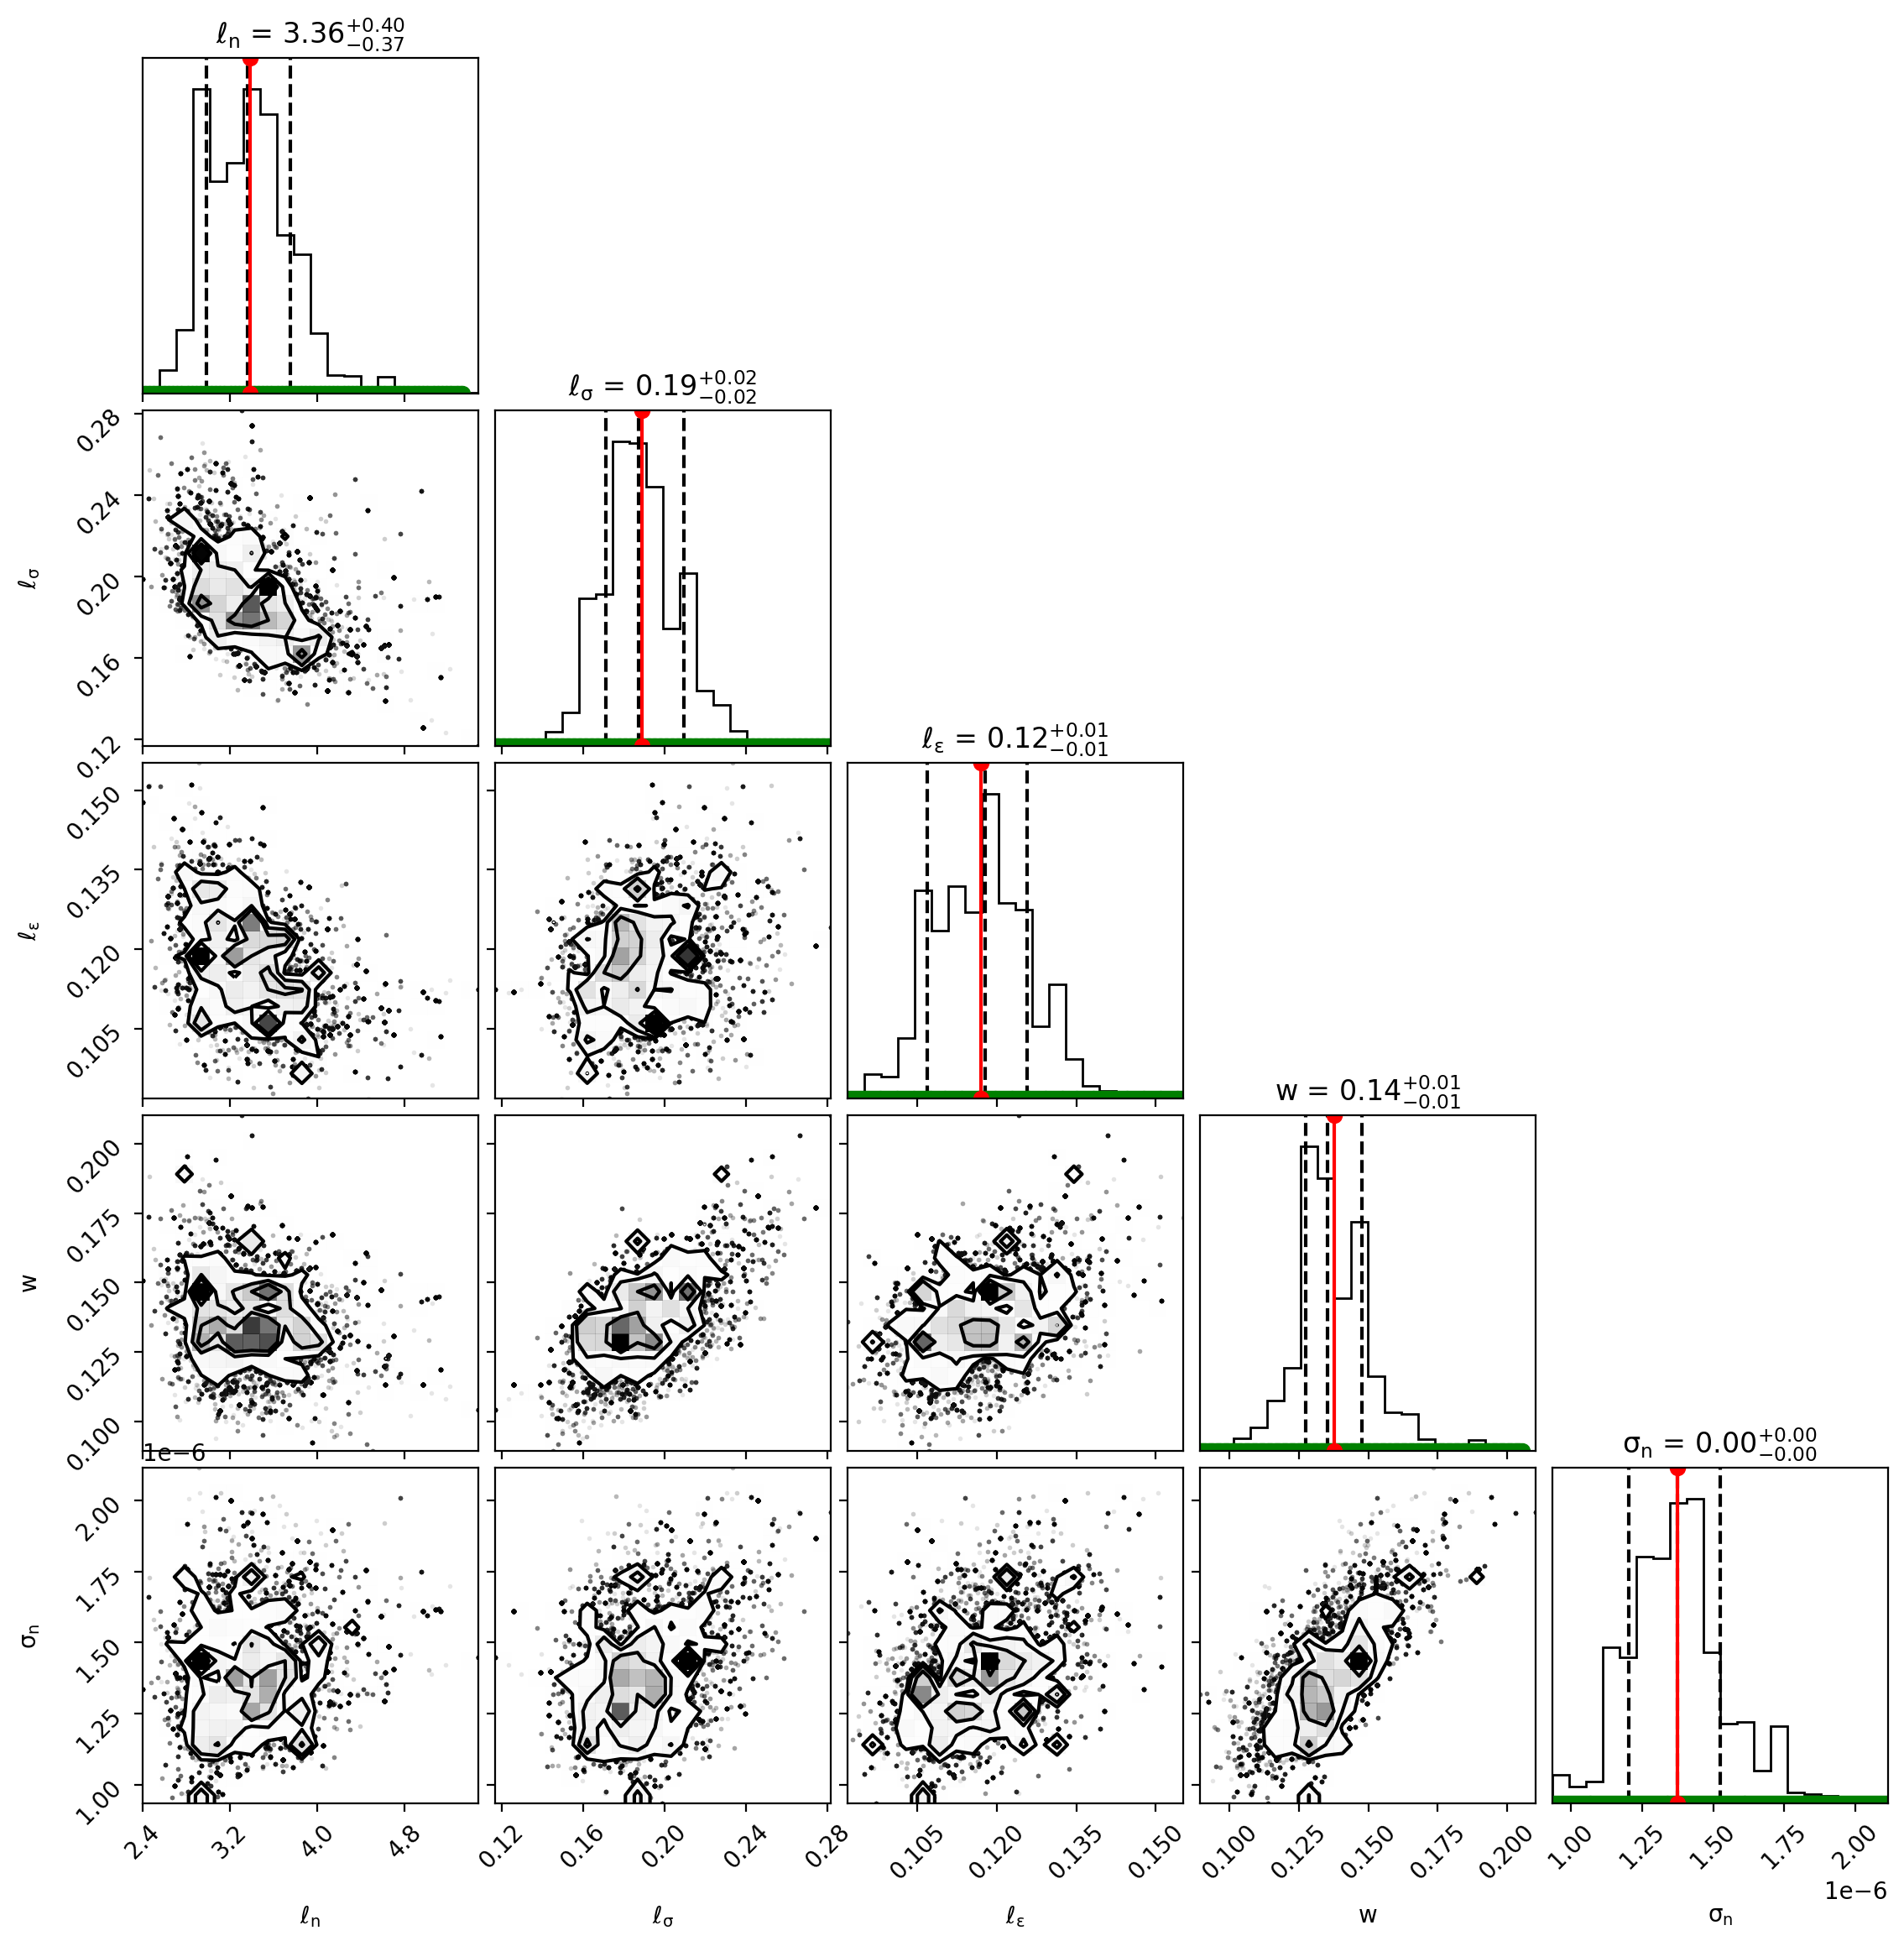

In [10]:
ndim=5
priors =[log_prior_ℓ_n,log_prior_ℓ_σ,log_prior_ℓ_ϵ,log_prior_w,log_prior_σn]

# Make the base corner plot
figure = corner.corner(np.exp(chain.reshape(5000*20,5)),labels=[
        r"$\ell_n$",
        r"$\ell_\sigma$",
        r"$\ell_\epsilon$",
        r"$w$",
        r"$\sigma_n$"
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},)

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    dimlo = np.mean(np.exp(chain.reshape(5000*20,5).T[i]))-5*np.std(np.exp(chain.reshape(5000*20,5).T[i]))
    dimhi = np.mean(np.exp(chain.reshape(5000*20,5).T[i]))+5*np.std(np.exp(chain.reshape(5000*20,5).T[i]))
    x = torch.linspace(dimlo,dimhi,200)
    ax.plot(x,priors[i](x).exp(),color="g",marker='o')

bruh = [3.38224890e+00, 1.88830504e-01, 1.16976918e-01, 1.37565712e-01,1.37362647e-06]    

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(bruh[i],color="r",marker='o')
    
plt.savefig('figures/hyperparam_posterior', dpi = 600)
plt.show()

In [11]:
MEAN_hp = np.mean(np.exp(chain.reshape(5000*20,5)),axis=0)
std_hp = np.std(np.exp(chain.reshape(5000*20,5)),axis=0)
cov_hp = np.cov(np.exp(chain.reshape(5000*20,5)).T)
print("MEAN HP:", MEAN_hp)
print("STD HP:",std_hp)
print("COV HP:",cov_hp)

MEAN HP: [3.38224890e+00 1.88830504e-01 1.16976918e-01 1.37565712e-01
 1.37362647e-06]
STD HP: [3.89479173e-01 1.91680123e-02 8.99730889e-03 1.35547792e-02
 1.74293459e-07]
COV HP: [[ 1.51695543e-01 -3.89617586e-03 -1.49238286e-03 -1.03972136e-03
   8.43005900e-09]
 [-3.89617586e-03  3.67416370e-04  3.59517276e-05  1.51159616e-04
   1.19740494e-09]
 [-1.49238286e-03  3.59517276e-05  8.09523768e-05  4.49536365e-05
   5.91453535e-10]
 [-1.03972136e-03  1.51159616e-04  4.49536365e-05  1.83733876e-04
   1.72273126e-09]
 [ 8.43005900e-09  1.19740494e-09  5.91453535e-10  1.72273126e-09
   3.03785136e-14]]


In [12]:
output_dict = dict(mean = MEAN_hp, cov = cov_hp)
dump(output_dict, open('training_data/hyperparameter/hyperParams_laplace.p', 'wb'))

In [ ]:
try:
    print("Attempting to load previously calculated hyper parameters")
    
    from pickle import load
    input_dict = load(open('training_data/hyperparameter/hyperParams.p', 'rb'))
    results = input_dict['results']
    hyperParamOptions = input_dict['hyperParamOptions']
    print("Success!!!")
    
except:
    print("Failed")
    
    ℓ_nmin = 0.5
    ℓ_nmax = 4
    
    ℓ_σmin = 0.01
    ℓ_σmax = 0.05
    
    ℓ_ϵmin = 0.001
    ℓ_ϵmax = 0.01
    
    w_min = 1e-4
    w_max = 1e-1
    
    σn_min = 1e-4
    σn_max = 1e-2
    
    
    # Creates a set of hyper parameters to compare
    trials = 5_000
    hyperParamOptions = torch.zeros((trials,5))
    hyperParamOptions[:,0] = (ℓ_nmax - ℓ_nmin) * torch.rand(trials) + ℓ_nmin
    hyperParamOptions[:,1] = (ℓ_σmax - ℓ_σmin) * torch.rand(trials) + ℓ_σmin
    hyperParamOptions[:,2] = (ℓ_ϵmax - ℓ_ϵmin) * torch.rand(trials) + ℓ_ϵmin
    hyperParamOptions[:,3] = (w_max  - w_min)  * torch.rand(trials) + w_min
    hyperParamOptions[:,4] = (σn_max - σn_min) * torch.rand(trials) + σn_min

    # Queue up function calls into dask
    lazy_results = []
    for i in range(trials):
        lazy_results.append(dask.delayed(g)(hyperParamOptions[i]))

    print("Queued Lazy Results")

    results = dask.compute(*lazy_results)
        
    output_dict = dict(results = results, hyperParamOptions = hyperParamOptions) # logMarginalLHArr = logMarginalLHArr
    dump(output_dict, open('training_data/hyperparameter/hyperParams.p', 'wb'))
    
    print("Done")

In [ ]:
print('Optimal hyperparameters based on the LOO error')
hyperParamOptions[torch.argmin(torch.tensor(results))]

## Validation

In [9]:
nsims_tr = 160
ndims    = 3
input_dict = load(open('testing_data/testing_samples.p', 'rb'))
xs_test = torch.tensor(input_dict['xs_test'])

input_dict = load(open('testing_data/test_data.p', 'rb'))
rdfs_test_bruh = input_dict['sqs']

In [10]:
#arr = hyperParamOptions[torch.argmin(torch.tensor(results))]
MEAN_hp = [3.38224890e+00, 1.88830504e-01, 1.16976918e-01, 1.37565712e-01, 1.37362647e-06]
arr    = MEAN_hp
l      = torch.tensor([arr[0],arr[1],arr[2]]).float()
w      = torch.tensor(arr[3]).float()
σn     = torch.tensor(arr[4]).float()
Kdd    = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
KddInv = torch.linalg.inv(Kdd)
Xi     = xs_test.float()

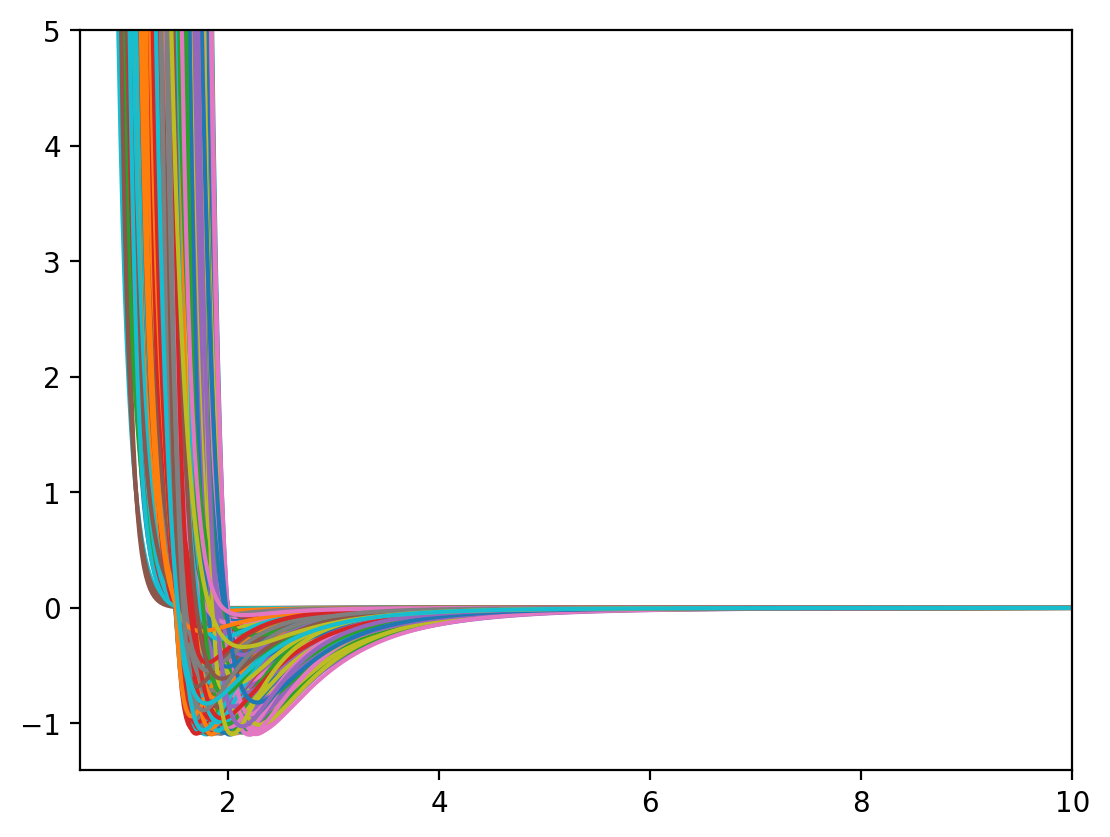

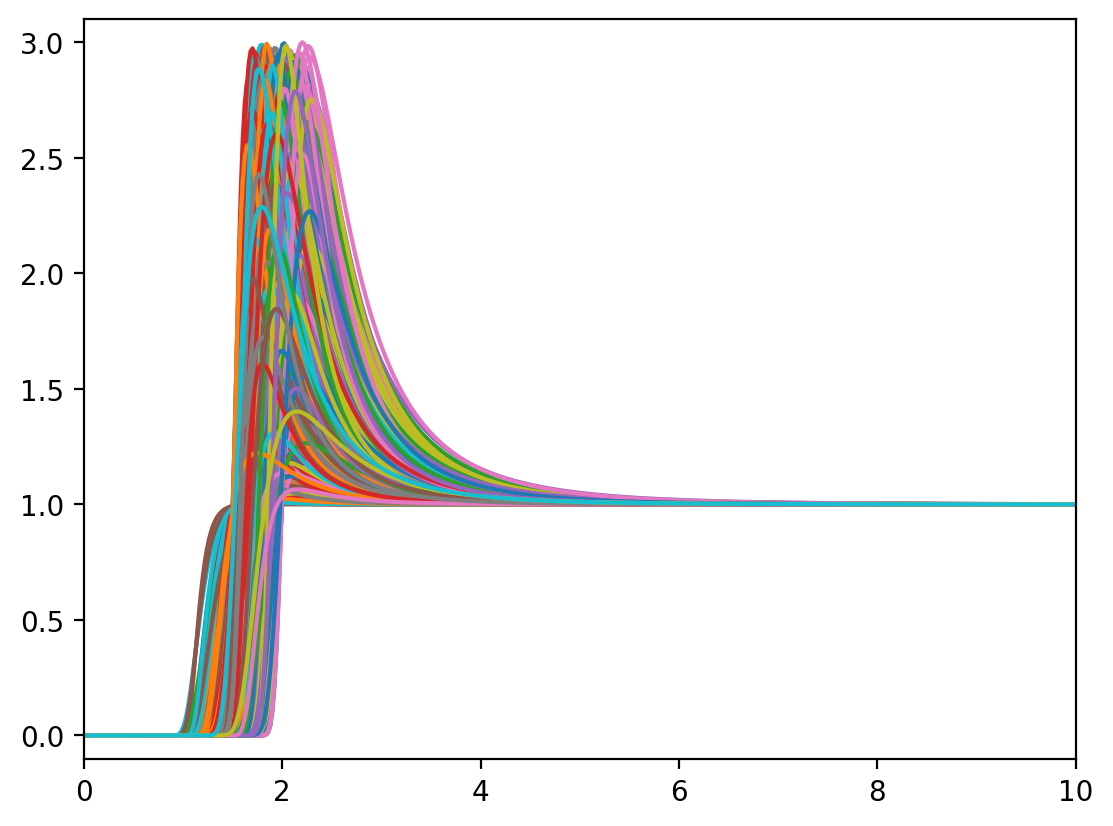

In [11]:
plt.plot(r_pr,Vd.T)
plt.xlim(0.6, 10)
plt.ylim(-1.4,5)
plt.show()

plt.plot(r_pr,pmf_r.T)
plt.xlim(0, 10)
plt.ylim(-0.1,3.1)
plt.show()

In [12]:
# plt.plot(q,μd.T, color = 'k', alpha = 0.1,  label = 'Prior Mean')
# plt.plot(q,sqs.T, color = 'r', alpha = 0.1, label = 'True')
# plt.axvline(3)
# plt.xlim(qmin, qmax)
# plt.ylim(-2,2.2)
# plt.show()

In [15]:
GPOut = local_surrogate(Xi, Xd, l, w, y, KddInv, μd)

In [16]:
RMSE = torch.sqrt(torch.mean((GPOut.T - rdfs_test_bruh)**2,dim=0))
RMSE_total = torch.sqrt(torch.mean((GPOut.T - rdfs_test_bruh)**2))

print(np.sqrt(torch.sum(RMSE**2/qnum)))
print(RMSE_total)

tensor(0.0036, dtype=torch.float64)
tensor(0.0036, dtype=torch.float64)


In [ ]:
err = torch.zeros(nsims_tr)
for i in range(nsims_tr):
    err[i] = torch.sqrt(torch.sum((GPOut.T[i] - rdfs_test_bruh[i])**2)/qnum)

In [ ]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 9))
# axs[0,0].scatter(xs_test[:,0], err, color = 'r', alpha = 0.6, edgecolors = 'k')
# #axs[0,0].hlines(0.03,xmin=min(xs_test[:,0]),xmax=max(xs_test[:,0]),color='k',linestyle='dashed')
# axs[0,0].set_xlabel('λ', fontsize = 16)
# axs[0,0].set_ylabel('RMSE', fontsize = 16)
# #axs[0,0].text(10.8, 0.076, '(a)', fontsize = 16)
# #axs[0,1].hlines(0.03,xmin=min(xs_test[:,1]),xmax=max(xs_test[:,1]),color='k',linestyle='dashed')
# axs[0,1].scatter(xs_test[:,1], err, color = 'r', alpha = 0.6, edgecolors = 'k')
# axs[0,1].set_xlabel('σ (Å)', fontsize = 16)
# axs[0,1].set_ylabel('RMSE', fontsize = 16)
# #axs[0,1].text(2.92, 0.076, '(b)', fontsize = 16)
# axs[1,0].scatter(xs_test[:,2], err, color = 'r', alpha = 0.6, edgecolors = 'k')
# #axs[1,0].hlines(0.03,xmin=min(xs_test[:,2]),xmax=max(xs_test[:,2]),color='k',linestyle='dashed')
# axs[1,0].set_xlabel('ϵ (kcal/mol)', fontsize = 16)
# axs[1,0].set_ylabel('RMSE', fontsize = 16)
# #axs[1,0].text(0.087, 0.076, '(c)', fontsize = 16)
# #axs[1,1].plot(r,RMSE, color = 'k', label = 'Mean', linestyle = '-')
# axs[1,1].plot(q,RMSE, color = 'k', label = 'Mean', linestyle = '-')
# axs[1,1].set_xlim(q[0], q[-1])
# #axs[1,1].axvline(3)
# axs[1,1].set_xlabel('q (Å$^{-1}$)', fontsize = 16)
# axs[1,1].set_ylabel('RMSE', fontsize = 16)
# #axs[1,1].text(13.6, 0.095, '(d)', fontsize = 16)
# plt.savefig('figures/surrogate_rmse', dpi = 600)
# plt.show()

In [ ]:
# XdNew = torch.tensor([[Xd[0][0],Xd[0][1]+0.1,Xd[0][2]]])

In [ ]:
# plt.plot(q,local_surrogate(Xi[0].unsqueeze(dim=0), Xd, l, w, y, KddInv, μd))
# plt.plot(q,rdfs_test_bruh[0])
# plt.show()

In [ ]:
# import freud
# import gsd.hoomd

In [ ]:
# traj = gsd.hoomd.open('training_data/traj/mie_train_' + str(0) + '.gsd', 'r')
# box = freud.box.Box.from_box(traj[0].configuration.box[:3])

In [ ]:
# for i in range(160):
#     rdf0 = freud.density.RDF(bins=rnum, r_min = rmin, r_max=rmax)
#     traj = gsd.hoomd.open('training_data/traj/mie_train_' + str(i) + '.gsd', 'r')
#     for frame in traj:
#         rdf0.compute(system=(box,frame.particles.position), reset=False)
#     # Get bin centers, RDF data from attributes
#     plt.plot(rdf0.bin_centers,rdf0.rdf)
#     plt.vlines(Xd[i][1],0,2,color='r',linestyle='dashed')
#     plt.title(Xd[i])
#     plt.show()

In [ ]:
XdNew = torch.tensor([[Xd[69][0]+1,Xd[69][1],Xd[69][2]]])

plt.plot(q,rdf2sq2(rdf0.bin_centers,rdf0.rdf,q.detach().numpy(),ρ)+1)
plt.plot(q,y[69])
plt.plot(q,local_surrogate(Xd[69].unsqueeze(dim=0), Xd, l, w, y, KddInv, μd))
plt.plot(q,local_surrogate(XdNew, Xd, l, w, y, KddInv, μd))

In [ ]:
def se_dkernel(Kid,x1,x2,di,l):
    import numpy as np
    KidD = torch.zeros((len(x1), len(x2)))
    for i in range (len(x1)):
        for j in range (len(x2)):
            KidD[i][j] = Kid[i][j] *(x2[j][di] - x1[i][di])/(l[di]**2)
    return KidD

Kid = se_kernel(Xi, Xd, l, w)
derivKid = se_dkernel(Kid,Xi,Xd,0,l)
KidKddInv = (derivKid @ KddInv)
μ_n = (KidKddInv @ (y)).T

derivKid = se_dkernel(Kid,Xi,Xd,1,l)
KidKddInv = (derivKid @ KddInv)
μ_σ = (KidKddInv @ (y)).T

derivKid = se_dkernel(Kid,Xi,Xd,2,l)
KidKddInv = (derivKid @ KddInv)
μ_ϵ = (KidKddInv @ (y)).T

μ_deriv_i      = interpolate.splrep(r,μ_n, s=0)
μ_deriv_smooth_n = torch.from_numpy(interpolate.splev(r_smooth, μ_deriv_i , der=0))

μ_deriv_i      = interpolate.splrep(r,μ_σ, s=0)
μ_deriv_smooth_σ = torch.from_numpy(interpolate.splev(r_smooth, μ_deriv_i , der=0))

μ_deriv_i      = interpolate.splrep(r,μ_ϵ, s=0)
μ_deriv_smooth_ϵ = torch.from_numpy(interpolate.splev(r_smooth, μ_deriv_i , der=0))

fig, ax = plt.subplots(3,1, figsize = (14,12),dpi=80)

ax[0].plot(r_smooth,50*μ_deriv_smooth_n,label='50*dGP(r)/dn @ MAP Estimate')
ax[0].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['k'], alpha = 0.1)
ax[0].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['none'], label = 'g(r)')
ax[0].plot(r_smooth,μ_MCMC_smooth,label="μ", color = 'k')
ax[0].fill_between(r_smooth,μ_MCMC_smooth+2*σ_MCMC_smooth, μ_MCMC_smooth - 2*σ_MCMC_smooth,label="μ $\pm$ 2σ",alpha=0.2, color ='r')
ax[0].set_title("50*dGP(r)/dn @ MAP Estimate")

ax[1].plot(r_smooth,0.5*μ_deriv_smooth_σ,label='0.5*dGP(r)/dσ @ MAP Estimate')
ax[1].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['k'], alpha = 0.1)
ax[1].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['none'], label = 'g(r)')
ax[1].plot(r_smooth,μ_MCMC_smooth,label="μ", color = 'k')
ax[1].fill_between(r_smooth,μ_MCMC_smooth+2*σ_MCMC_smooth, μ_MCMC_smooth - 2*σ_MCMC_smooth,label="μ $\pm$ 2σ",alpha=0.2, color ='r')
ax[1].set_title("0.5*dGP(r)/dσ @ MAP Estimate")

ax[2].plot(r_smooth,0.2*μ_deriv_smooth_ϵ,label='0.2*dGP(r)/dϵ @ MAP Estimate')
ax[2].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['k'], alpha = 0.1)
ax[2].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['none'], label = 'g(r)')
ax[2].plot(r_smooth,μ_MCMC_smooth,label="μ", color = 'k')
ax[2].fill_between(r_smooth,μ_MCMC_smooth+2*σ_MCMC_smooth, μ_MCMC_smooth - 2*σ_MCMC_smooth,label="μ $\pm$ 2σ",alpha=0.2, color ='r')
ax[2].set_title("0.2*dGP(r)/dϵ @ MAP Estimate'")

ax[2].set_xlabel('r (Å)', fontsize = 16)
ax[1].set_ylabel('g(r)', fontsize = 16)
plt.show()